# CS-513 Final Exam

## Question 2
___
Wyatt Blair

5/6/2024
___


In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import matplotlib.pyplot as plt

___
## Import Data

In [2]:
data = pd.read_csv('../data/KY_NJ_Zip.csv')
data

,STATEFIPS,STATE,zipcode,Returns_pct1,Returns_pct2,Returns_pct3,Returns_pct4,Returns_pct5,Returns_pct6,total
0,21,KY,40003,34.48,25.29,14.94,12.64,12.64,0.00,870
1,21,KY,40004,36.60,26.94,14.85,9.59,10.02,1.99,14070
2,21,KY,40006,36.79,25.00,16.51,10.38,10.38,0.94,2120
3,21,KY,40007,41.67,33.33,0.00,25.00,0.00,0.00,120
4,21,KY,40008,36.52,26.40,15.73,10.67,10.67,0.00,1780
...,...,...,...,...,...,...,...,...,...,...
1238,34,NJ,8887,23.88,22.39,19.40,11.94,17.91,4.48,670
1239,34,NJ,8889,23.25,13.63,10.22,9.02,24.85,19.04,4990
1240,34,NJ,8901,50.37,30.12,10.18,3.89,4.21,1.23,18760
1241,34,NJ,8902,29.67,22.66,14.69,10.27,17.09,5.62,20830


In [3]:
data.isnull().any()

STATEFIPS       False
STATE           False
zipcode         False
Returns_pct1    False
Returns_pct2    False
Returns_pct3    False
Returns_pct4    False
Returns_pct5    False
Returns_pct6    False
total           False
dtype: bool

In [4]:
state_map = data[['STATE', 'STATEFIPS']].drop_duplicates()
state_map

,STATE,STATEFIPS
0,KY,21
667,NJ,34


In [5]:
data.drop(columns=['zipcode', 'STATEFIPS', 'total'], inplace=True)     # zipcode isn't useful here and STATE dulpicates STATEFIPS

In [6]:
# normalize data so Euclidean distance makes sense
norm_data = pd.DataFrame(
    data=StandardScaler().fit_transform(
        data.replace({'NJ': 1, 'KY': 0})
    ),
    columns=data.columns
)

In [7]:
target = 'STATE'
features = norm_data.columns.to_list(); features.remove(target)

In [8]:
X = norm_data[features].values
y = norm_data[target].values

___
## Problem 2 - (15 points)

The “KY_NJ_Zip” CSV dataset on CANVAS categorizes the percentage of tax returns of families in the states of Kentucky and New Jersey into six categories (Returns_pct1 to Returns_pct6). Use these six categories and Euclidian distance, to perform the following analysis:

* Use the kmeans clustering method to create four clusters for the “KY_NJ_ZIP” dataset.
* Show the cross tabulation of the clusters versus the State.

___
### sklearn's Implementation

In [9]:
# clustering model
model = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(X)
unique_labels = np.unique(sorted(model.labels_))

In [10]:
data['cluster'] = model.predict(X)

In [11]:
pd.crosstab(data['STATE'], data['cluster'])

cluster,0,1,2,3
STATE,,,,
KY,80,123,456,8
NJ,9,288,107,172


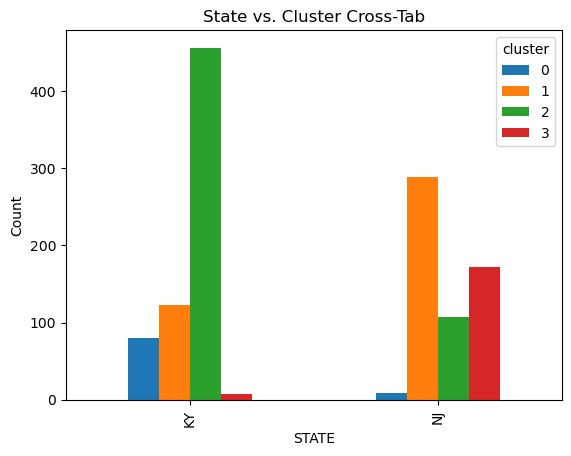

In [12]:
fig, ax = plt.subplots()

ax.set_title('State vs. Cluster Cross-Tab')
ax.set_ylabel('Count')

pd.crosstab(data['STATE'], data['cluster']).plot.bar(ax=ax)

plt.show()

___
### My implementation
#### K-Means

##### Assignment Step
$S_i^{(t)} = \{x_p : ||x_p - m_i^{(t)}||^2 \leq ||x_p - m_j^{(t)}||^2 ; \forall{j}, 1\leq j \leq k \}$ 

##### Update Step
$m_i^{(t+1)} = \frac{1}{|S_i^{(t)}} \sum_{x_j \in S_i^{(t)}}{x_j}$

In [13]:
# borrowed from my HW-9 submission

def minkowski_distance(x, y, p):

    diff = x - y
    power = diff ** p

    total = power.sum(axis=len(x.shape)-1)
    distance = total ** (1/p)

    return distance

def euclidean_distance(x, y):
    return minkowski_distance(x, y, p=2)

class KMeansClustering:

    def __init__(self, X: pd.DataFrame, k: int):

        self.X = X
        self.N, self.M = self.X.shape
        self.k = k

        self.random_start_points = self.X.sample(n=self.k)
        self.centroids = {k_ind: centroid for k_ind, centroid in enumerate(self.random_start_points.values)}
        self.centroids = pd.DataFrame().from_dict(self.centroids, orient='index', columns=self.X.columns)

    def assignment_step(self):
        
        self.distance_mat = pd.DataFrame(np.zeros((self.N, self.k)), index=self.X.index, columns=self.centroids.index)
        for centroid_ind, centroid in self.centroids.iterrows():
            
            tiled_centroid = np.repeat(centroid.values[:, np.newaxis], repeats=self.N, axis=1).T
            distances = euclidean_distance(tiled_centroid, self.X)
            self.distance_mat[centroid_ind] = distances
        
        self.clusters = self.distance_mat.idxmin(axis=1)
        return self.clusters

    def update_step(self):
        
        for k_ind in self.centroids.index:
            
            cluster_mask = self.clusters.values == k_ind
            points_in_cluster_inds = self.clusters[cluster_mask].index
            points_in_cluster = self.X.loc[points_in_cluster_inds]
            
            new_centroid = points_in_cluster.sum(axis=0) / len(points_in_cluster.index)
            self.centroids.loc[k_ind] = new_centroid

    def fit(self):
        
        # initialize vars
        init_clusters = self.assignment_step()
        self.update_step()
        fin_clusters = self.assignment_step()

        # keep going until the clusters are stable
        while (init_clusters != fin_clusters).any():
            
            init_clusters = fin_clusters
            self.update_step()
            fin_clusters = self.assignment_step()

In [14]:
k_means = KMeansClustering(
    X=norm_data[features],
    k=4,
)

k_means.fit()

In [15]:
data['cluster_home-brewed'] = k_means.clusters

In [16]:
pd.crosstab(data['STATE'], data['cluster_home-brewed'])

cluster_home-brewed,0,1,2,3
STATE,,,,
KY,123,8,80,456
NJ,288,172,9,107


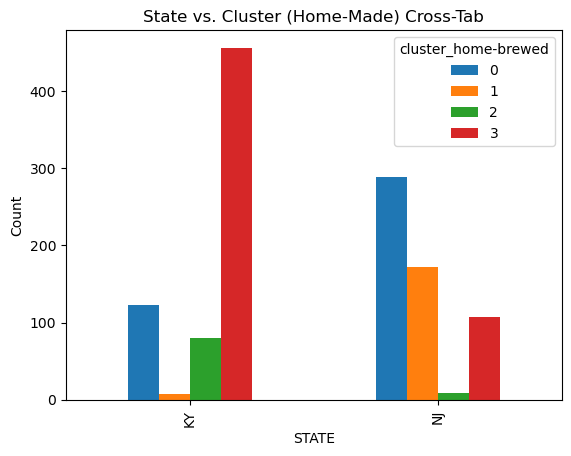

In [17]:
fig, ax = plt.subplots()

ax.set_title('State vs. Cluster (Home-Made) Cross-Tab')
ax.set_ylabel('Count')

pd.crosstab(data['STATE'], data['cluster_home-brewed']).plot.bar(ax=ax)

plt.show()